In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/DATA/mb_data.csv')

Mounted at /content/drive


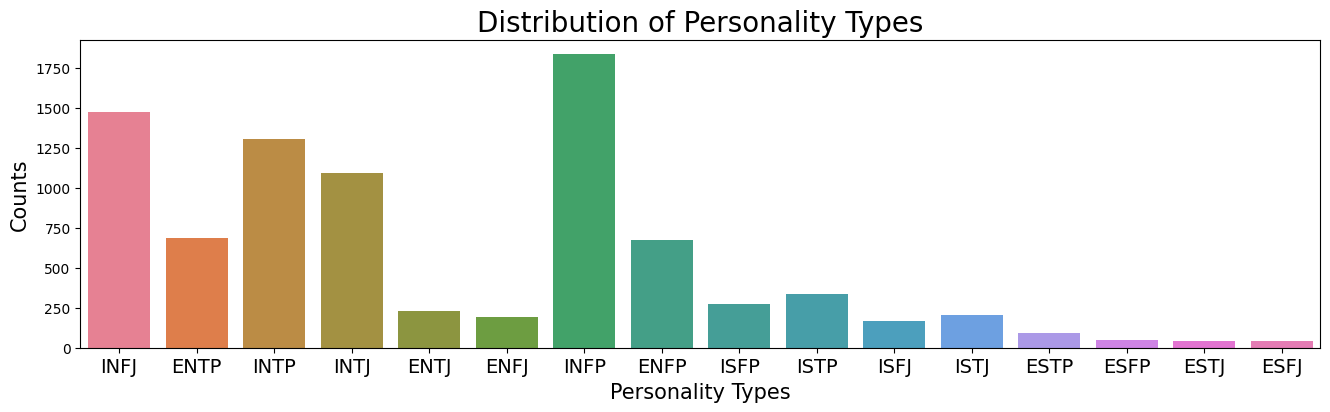

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
def show_class_distribution(data, x="type", figsize=(16,4), title="Distribution of Personality Types", xticks_size=10, palette="husl"):
    plt.figure(figsize=figsize)
    sns.countplot(x=x, data=data, palette=palette)
    plt.xlabel("Personality Types", size=15)
    plt.ylabel("Counts", size=15)
    plt.xticks(size=xticks_size)
    plt.title(title, size=20)
    plt.show()
show_class_distribution(data, xticks_size=14)

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
  Using cached tokenizers-0.13.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached huggingface_hub-0.13.4-py3-none-any.whl (200 kB)


In [5]:
import pandas as pd
import re
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [ ]:
import pandas as pd
import re
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the MBTI dataset
df = data
df.columns = ['type', 'tweets']

# Calculate the count of each personality type
type_counts = df["type"].value_counts()

# Find the class with the maximum count
max_count = type_counts.max()

# Define the batch size
batch_size = 5

# Load the GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)

# Loop through each personality type and generate synthetic data
m=0
for personality_type, count in type_counts.items():
    if count < max_count:
        # Calculate the number of synthetic data points to generate
        num_synthetic = max_count - count
        
        # Get the tweets for the current personality type
        tweets = df[df["type"] == personality_type]["tweets"]
        
        # Join the tweets into a single string
        text = " ||| ".join(tweets)
        
        # Clean the text by removing URLs and special characters
        text = re.sub(r"http\S+", "", text)
        # text = re.sub(r"[^a-zA-Z0-9 |||]", "", text)
        
        # Split the text into batches
        num_batches = int(num_synthetic / batch_size) + 1
        batches = [text[i:i+50] for i in range(0, len(text), 50)]
        
        # Generate synthetic data for each batch
        for i in range(num_batches):
            start_index = i * batch_size
            end_index = min((i + 1) * batch_size, num_synthetic)
            batch_size_current = end_index - start_index
            
            # Join the current batch into a single string
            current_text = " ||| ".join(batches[i:i+batch_size_current])
            
            # Tokenize the current batch
            inputs = tokenizer(current_text, return_tensors="pt")
            
            # Generate synthetic data using GPT-2
            output = model.generate(
                inputs["input_ids"],
                max_length=500,
                do_sample=True,
                temperature=0.7,
                num_return_sequences=batch_size_current
            )
            
            # Convert the generated tokens back to text
            generated_tweets = []
            for j in range(batch_size_current):
                generated_tweet = tokenizer.decode(output[j], skip_special_tokens=True)
                generated_tweets.append(generated_tweet)
            
            # Join the generated tweets into a single string with '|||' separators
            generated_text = " ||| ".join(generated_tweets)
            
            print(m)
            m=m+1
            # Add the generated data to the original dataframe
            for j in range(start_index, end_index):
                df = df.append({
                    "type": personality_type,
                    "tweets": generated_text
                }, ignore_index=True)
            
# Save the oversampled dataset to a new CSV file
df.to_csv("mbti_data_oversampled.csv", index=False)